In [3]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
from h3 import h3
import datetime
import os, inspect
import matplotlib.pyplot as plt
import importlib
importlib.reload(a)

<module 'analysis' from '../analysis.py'>

In [4]:
db=commu.connecttoLocaldb(database='twitter')

The idea is to estimate a model where to test the hypothesis that the trend of growth of tweets in places with typologies in the process of gentrification or at risk of gentrification were higher.

We propose a baseline specification as follows:

$$log(tweets) = \beta_0 t+\sum_j \delta_j t Dtypo_j + \sum_t Dyear_t+ \sum_j Dtypo_j + \epsilon $$


 Es importante tambien sumar efectos fijos para momentos del tiempo.

La hipotesis seria que \beta_j es dis

In [5]:
# Get counts at hex level 
df=a.hexcountsresults_to_df(db, save=False)


## Adding census tracts data  to hexs

In [6]:
#dfcentroids=myh3.df_with_hexid_to_centroids_gdf(df, hexcolname='_id')

In [7]:
from shapely.geometry import Point
def df_with_hexid_to_centroids_gdf(df, hexcolname='hexid'):

    """ Transforms dataframe with hexid column to a geodataframe with centroids as geometries
    :param hexcolname: name of the hexid column
    :returns gdf
    """
    seriesofcoordinates=df[hexcolname].apply(h3.h3_to_geo)
    geometria=seriesofcoordinates.apply(lambda row: Point(row[0],row[1]))
    gdf=gpd.GeoDataFrame(df, geometry=geometria)
    return gdf

dfcentroids=df_with_hexid_to_centroids_gdf(df, hexcolname='_id')

In [8]:
dfcentroids.head(3)

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time,geometry
0,89dd686e037ffff,1388448000000,1.0,1.0,NaN,1.0,2013-12-31,POINT (-58.63231021289359 -34.26962237322005)
1,89dd686e0b3ffff,1388448000000,10.0,10.0,NaN,10.0,2013-12-31,POINT (-58.64167222372094 -34.2730928847364)
2,89dd6b840b3ffff,1388448000000,1.0,1.0,NaN,1.0,2013-12-31,POINT (-58.28642922668017 -34.91763556397075)


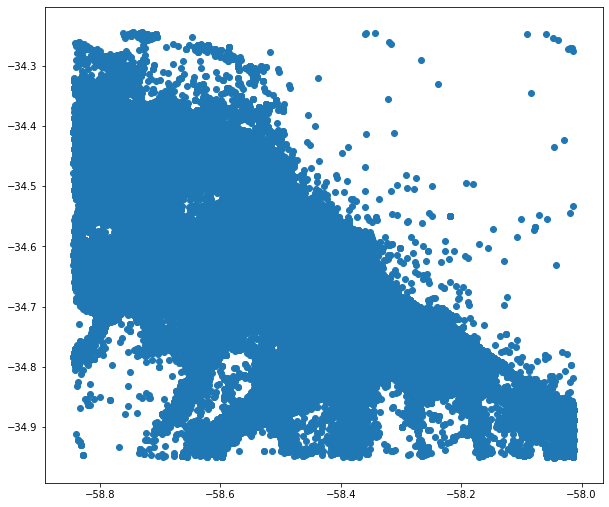

In [9]:

dfcentroids.plot()

In [10]:
"""
crs_ciudad={'proj': 'tmerc',
     'lat_0': -34.6297166,
     'lon_0': -58.4627,
     'k': 0.999998,
     'x_0': 100000,
     'y_0': 100000,
     'ellps': 'intl',
     'units': 'm',
     'no_defs': True}
dfcentroids.crs={'init': 'epsg:4326', 'no_defs': True}
dfcentroids=dfcentroids.to_crs(crs_ciudad)
"""

"\ncrs_ciudad={'proj': 'tmerc',\n     'lat_0': -34.6297166,\n     'lon_0': -58.4627,\n     'k': 0.999998,\n     'x_0': 100000,\n     'y_0': 100000,\n     'ellps': 'intl',\n     'units': 'm',\n     'no_defs': True}\ndfcentroids.crs={'init': 'epsg:4326', 'no_defs': True}\ndfcentroids=dfcentroids.to_crs(crs_ciudad)\n"

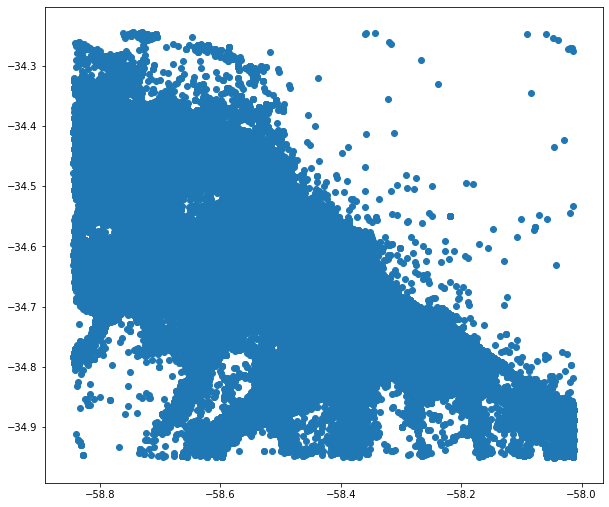

In [11]:
dfcentroids.plot()

In [13]:
#dfcentroids=myh3.df_with_hexid_to_centroids_gdf(df, hexcolname='_id')

# Spatial Join
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
tracts = gpd.read_file(currentdir+'/../data/radios_amba_2010.shp')
tracts=tracts.to_crs({'init': 'epsg:4326'})

# Spatial Join between centroids and census track shapes
dfcentroids=gpd.sjoin(dfcentroids, tracts, how="inner", op='intersects')

# Since in my case I do not have the typologies with the census tract data, I still need to merge it by censustrackid
typologies=pd.read_excel(currentdir+'/../data/tipologias/'+'tipologias.xlsx')


typologies.loc[typologies['TYPE']=='GDV','TYPE' ]="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GD','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='G','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='DV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='D','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='VE','TYPE']="Exclusive Dynamic"
typologies.loc[typologies['TYPE']=='V','TYPE']="Low Income, At Risk of Change"
typologies.loc[typologies['TYPE']=='E','TYPE']="Exclusive Static"


dfcentroids=dfcentroids.merge(typologies[['COD_2010','TYPE']], left_on='cod_radio', right_on='COD_2010')

/home/rickhunter/miniconda3/envs/prueba/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rickhunter/miniconda3/envs/prueba/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rickhunter/miniconda3/envs/prueba/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


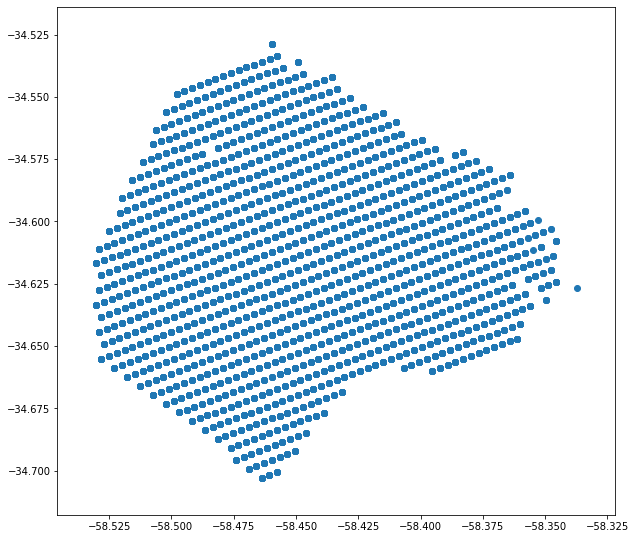

In [14]:
dfcentroids.plot()

## Grouping at the tract level

In [15]:
df_tract_level=dfcentroids[['nonresidents','nonresidentsandnonneighbors','residents','totalcounts','COD_2010','time']].groupby(['COD_2010','time']).sum().reset_index()
typologies_code=dfcentroids[['COD_2010','TYPE']].drop_duplicates()
df_tract_level=df_tract_level.merge(typologies_code, left_on='COD_2010', right_on='COD_2010')
df_tract_level.head(3)

,COD_2010,time,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,TYPE
0,20010101,2012-09-30,995.0,970.0,39.0,1034.0,"Low Income, Undergoing Change"
1,20010101,2012-12-31,1996.0,1969.0,66.0,2062.0,"Low Income, Undergoing Change"
2,20010101,2013-03-31,2756.0,2662.0,592.0,3348.0,"Low Income, Undergoing Change"


In [16]:
df_tract_level.TYPE.unique()

array(['Low Income, Undergoing Change', 'Low Income, At Risk of Change',
       'Exclusive Static', 'OTHER', 'Exclusive Dynamic', 'NON POP',
       'NON_POP'], dtype=object)

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [18]:
def regress(lista, data):
  """ 
  Funcion que realiza la regresion OLS
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.OLS(Y,X)
  resultados=modelo.fit()
  print(resultados.summary())

In [38]:
df_tract_level['days']=(df_tract_level.time-datetime.datetime(2012,9,30)).dt.days

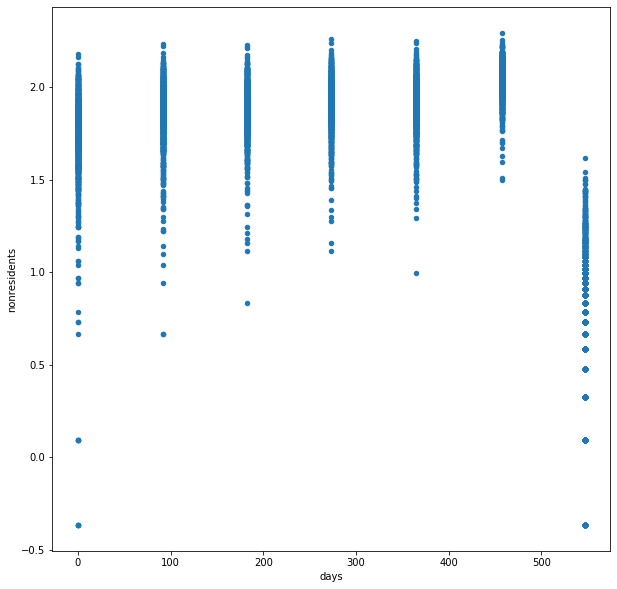

In [67]:
df_tract_level.plot.scatter(x='days',y='nonresidents')
#ojo voy a tener que controlar por la muestra porque el ultimo periodo tiene menos datos

In [58]:
df_tract_level['lognonresidents']=np.log(df_tract_level.nonresidents)

/home/rickhunter/miniconda3/envs/prueba/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [68]:
datos=df_tract_level[['lognonresidents','nonresidents','days','TYPE','time']]
# el metodo dropna() me permite eliminar las filas que tienen algun valor missing
datos=datos.dropna()

In [69]:
import numpy as np
results = smf.ols('lognonresidents ~  days*C(TYPE)+ C(time)', data=datos).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        lognonresidents   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     514.3
Date:                Fri, 11 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:35:36   Log-Likelihood:                -37.499
No. Observations:                6161   AIC:                             113.0
Df Residuals:                    6142   BIC:                             240.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [70]:
import numpy as np
results = smf.ols('nonresidents ~  days*C(TYPE)+ C(time)', data=datos).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           nonresidents   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1315.
Date:                Fri, 11 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:38:48   Log-Likelihood:                 1876.1
No. Observations:                6161   AIC:                            -3714.
Df Residuals:                    6142   BIC:                            -3586.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------